In [59]:
# ---- Setup: Install dependencies ----
!python3 -m pip install -q pandas numpy scikit-learn matplotlib yfinance xgboost torch
!python3 -m pip install -q transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [60]:
import yfinance as yf, pandas as pd
from pathlib import Path

Path("data/raw").mkdir(parents=True, exist_ok=True)
spy = yf.download("SPY", start="2015-01-01", auto_adjust=True)
spy.to_csv("data/raw/SPY.csv")
print("Rows:", len(spy))
spy.head()

# Flatten columns if MultiIndex (Price/Ticker layout)
if isinstance(spy.columns, pd.MultiIndex):
    # keep the first level: Open, High, Low, Close, Volume
    spy.columns = spy.columns.get_level_values(0)

# keep standard OHLCV only
keep = [c for c in ["Open","High","Low","Close","Volume"] if c in spy.columns]
spy = spy[keep].apply(pd.to_numeric, errors="coerce")

# tidy index and save
spy = spy[~spy.index.duplicated(keep="first")].sort_index()
spy.to_csv("data/raw/SPY.csv")
print("Cleaned & saved:", spy.shape)
spy.head()



[*********************100%***********************]  1 of 1 completed

Rows: 2691
Cleaned & saved: (2691, 5)


Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,172.361441,172.779024,170.524067,171.568024,121465900
2015-01-05,170.515758,170.682788,168.160597,168.469604,169632600
2015-01-06,168.778599,169.304757,166.081017,166.882782,209151400
2015-01-07,168.219044,169.304762,167.768061,168.962341,125346700
2015-01-08,170.382079,172.177692,170.365385,171.960541,147217800


In [61]:
import numpy as np, pandas as pd
from pathlib import Path

def ichimoku(df: pd.DataFrame) -> pd.DataFrame:
    hi, lo, cl = df["High"], df["Low"], df["Close"]
    tenkan = (hi.rolling(9).max() + lo.rolling(9).min()) / 2
    kijun  = (hi.rolling(26).max() + lo.rolling(26).min()) / 2
    span_a = ((tenkan + kijun) / 2).shift(26)
    span_b = ((hi.rolling(52).max() + lo.rolling(52).min()) / 2).shift(26)
    chikou = cl.shift(-26)
    return pd.DataFrame(
        {"tenkan": tenkan, "kijun": kijun, "span_a": span_a, "span_b": span_b, "chikou": chikou},
        index=df.index
    )

# Read CSV with explicit date format (no warning), set index name
df = pd.read_csv(
    "data/raw/SPY.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d",
)
df.index.name = "Date"
df = df.apply(pd.to_numeric, errors="coerce").sort_index()

# safety check after df is loaded
expected = {"Open","High","Low","Close","Volume"}
missing = expected - set(df.columns)
assert not missing, f"Missing columns in CSV: {missing}"

# ---- Feature engineering ----
fe = pd.DataFrame(index=df.index)
fe["ret1"]  = df["Close"].pct_change(fill_method=None)
fe["sma20"] = df["Close"].rolling(20).mean()
fe = fe.join(ichimoku(df))

# Targets
fe["y_next_ret"] = df["Close"].pct_change(fill_method=None).shift(-1)
fe["y_up"] = (fe["y_next_ret"] > 0).astype(int)

# Finalize
fe = fe.dropna().copy()
Path("data/processed").mkdir(parents=True, exist_ok=True)
fe.to_csv("data/processed/SPY_features.csv")
print("Feature rows:", len(fe))
fe.head()


Feature rows: 2588


,ret1,sma20,tenkan,kijun,span_a,span_b,chikou,y_next_ret,y_up
Date,,,,,,,,,
2015-04-24,0.002320,175.111042,175.739770,174.52756,173.779118,171.250656,177.308517,-0.004158,0
2015-04-27,-0.004158,175.322025,175.953699,174.74149,173.779118,171.250656,177.778336,0.003179,1
2015-04-28,0.003179,175.455827,175.953699,174.74149,173.923590,171.250656,176.276642,-0.004115,0
2015-04-29,-0.004115,175.629475,175.953699,174.74149,173.942476,171.250656,175.974670,-0.010020,0
2015-04-30,-0.010020,175.745246,176.209583,174.74149,173.980066,171.250656,174.892532,0.010841,1


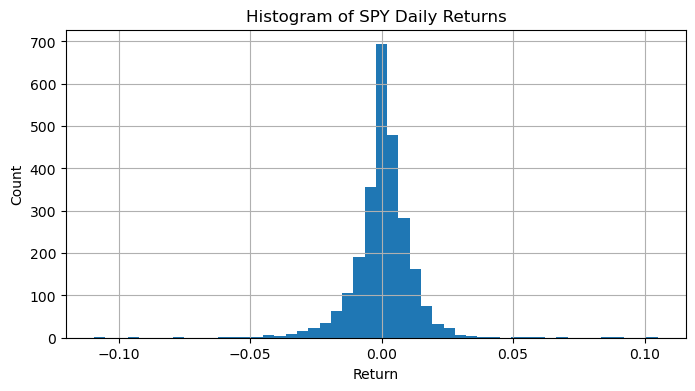

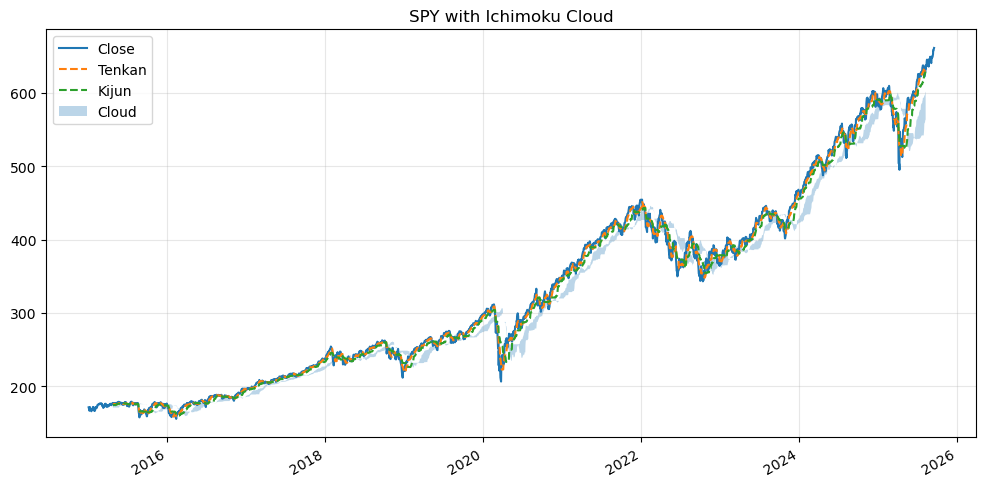

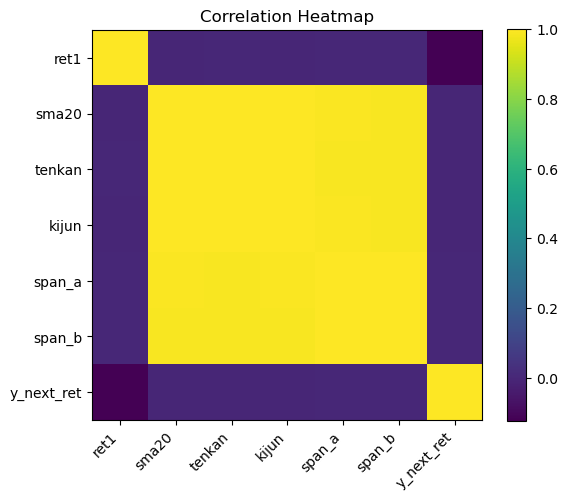

LinearRegression  MAE: 0.006933155951348585  R^2: -0.037405800723586013
LogisticRegression AUC: 0.47213695575815884  F1: 0.6775510204081633
XGBRegressor       MAE: 0.010845795614314119  R^2: -0.8120599419683237
XGBClassifier       AUC: 0.4793069745422336  F1: 0.23834196891191708


,model,target,MAE,R2,AUC,F1
0,LinearRegression,next_ret,0.006933,-0.037406,,
1,LogisticRegression,updown,,,0.472137,0.677551
2,XGBRegressor,next_ret,0.010846,-0.81206,,
3,XGBClassifier,updown,,,0.479307,0.238342


In [62]:
# === EDA + Baselines ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, f1_score
from xgboost import XGBRegressor, XGBClassifier

# Load features and price once
fe    = pd.read_csv("data/processed/SPY_features.csv", index_col=0, parse_dates=True)
price = pd.read_csv("data/raw/SPY.csv",            index_col=0, parse_dates=True)

# --- EDA ---
# 1) Histogram of daily returns
fe["ret1"].hist(bins=50, figsize=(8,4))
plt.title("Histogram of SPY Daily Returns"); plt.xlabel("Return"); plt.ylabel("Count"); plt.show()

# 2) Ichimoku overlay
plt.figure(figsize=(12,6))
plt.plot(price.index, price["Close"].values, label="Close")
plt.plot(fe.index, fe["tenkan"].values, "--", label="Tenkan")
plt.plot(fe.index, fe["kijun"].values,  "--", label="Kijun")
plt.fill_between(fe.index, fe["span_a"].values, fe["span_b"].values, alpha=0.3, label="Cloud")
plt.title("SPY with Ichimoku Cloud"); plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate(); plt.show()

# 3) Correlation heatmap
cols = ["ret1","sma20","tenkan","kijun","span_a","span_b","y_next_ret"]
corr = fe[cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest"); plt.title("Correlation Heatmap"); plt.colorbar()
plt.xticks(range(len(cols)), cols, rotation=45, ha="right"); plt.yticks(range(len(cols)), cols)
plt.tight_layout(); plt.show()

# --- Baseline train/test split ---
X = fe[["ret1","sma20","tenkan","kijun","span_a","span_b"]].values
y_reg = fe["y_next_ret"].values
y_cls = fe["y_up"].values

split = int(0.8*len(fe))
Xtr, Xte = X[:split], X[split:]
yr_tr, yr_te = y_reg[:split], y_reg[split:]
yc_tr, yc_te = y_cls[:split], y_cls[split:]

# Regression baseline (Linear)
reg = Pipeline([("sc", StandardScaler()), ("lr", LinearRegression())])
reg.fit(Xtr, yr_tr)
pred_r = reg.predict(Xte)
mae = mean_absolute_error(yr_te, pred_r)
r2  = r2_score(yr_te, pred_r)
print("LinearRegression  MAE:", mae, " R^2:", r2)

# Classification baseline (Logistic)
clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=2000))])
clf.fit(Xtr, yc_tr)
proba = clf.predict_proba(Xte)[:,1]
pred_c = (proba > 0.5).astype(int)
auc = roc_auc_score(yc_te, proba)
f1  = f1_score(yc_te, pred_c)
print("LogisticRegression AUC:", auc, " F1:", f1)

# XGBoost models
xgbr = XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8, random_state=42)
xgbc = XGBClassifier(n_estimators=400, max_depth=4, learning_rate=0.05,
                     subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", random_state=42)
xgbr.fit(Xtr, yr_tr); pred_rx = xgbr.predict(Xte)
xgbc.fit(Xtr, yc_tr); proba_x = xgbc.predict_proba(Xte)[:,1]

mae_x = mean_absolute_error(yr_te, pred_rx)
r2_x  = r2_score(yr_te, pred_rx)
auc_x = roc_auc_score(yc_te, proba_x)
f1_x  = f1_score(yc_te, (proba_x>0.5).astype(int))
print("XGBRegressor       MAE:", mae_x, " R^2:", r2_x)
print("XGBClassifier       AUC:", auc_x, " F1:", f1_x)

# Save tidy metrics table
os.makedirs("metrics", exist_ok=True)
metrics = pd.DataFrame([
  {"model":"LinearRegression","target":"next_ret","MAE":mae,"R2":r2},
  {"model":"LogisticRegression","target":"updown","AUC":auc,"F1":f1},
  {"model":"XGBRegressor","target":"next_ret","MAE":mae_x,"R2":r2_x},
  {"model":"XGBClassifier","target":"updown","AUC":auc_x,"F1":f1_x},
])
metrics.to_csv("metrics/model_comparison.csv", index=False)
metrics.fillna("")


In [63]:
# === FinBERT install + run + compare (clean, single cell) ===
import importlib, sys, subprocess, os
import numpy as np
import pandas as pd
import yfinance as yf
import torch
from torch.nn.functional import softmax

# 0) Ensure transformers is in THIS kernel
def ensure_pkg(pkg: str):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
ensure_pkg("transformers")
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Kernel:", sys.executable)

# 1) Pull recent headlines (fallback if empty). Produce tz-naive daily key as plain date
def fetch_news(ticker="SPY"):
    raw = yf.Ticker(ticker).news or []
    rows = []
    for n in raw:
        ts = pd.to_datetime(n.get("providerPublishTime", 0), unit="s", utc=True).tz_convert("America/New_York")
        rows.append({
            "time": ts,
            "date": ts.tz_convert(None).date(),   # <-- plain datetime.date (no tz)
            "title": n.get("title","")
        })
    return (pd.DataFrame(rows).dropna(subset=["title"]).sort_values("time").reset_index(drop=True))

news_df = fetch_news("SPY")
if news_df.empty:
    news_df = fetch_news("AAPL")  # ensure pipeline runs even if SPY has no recent headlines
print("Headlines:", len(news_df))

# 2) FinBERT scoring (neg/neu/pos + signed = pos - neg)
tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def finbert_scores(texts, batch=32):
    if not texts:
        return pd.DataFrame(columns=["neg","neu","pos","signed"])
    out = []
    for i in range(0, len(texts), batch):
        bx = texts[i:i+batch]
        inputs = tok(bx, return_tensors="pt", padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            logits = mdl(**inputs).logits
        probs = softmax(logits, dim=-1).cpu().numpy()  # [neg, neu, pos]
        out.extend(probs.tolist())
    df = pd.DataFrame(out, columns=["neg","neu","pos"])
    df["signed"] = df["pos"] - df["neg"]
    return df

if not news_df.empty:
    scores = finbert_scores(news_df["title"].tolist())
    news_df = pd.concat([news_df, scores], axis=1)

# 3) Daily sentiment aggregates (plain date)
if not news_df.empty:
    daily = (news_df.groupby("date")
             .agg(fin_sent_mean=("signed","mean"),
                  fin_pos_mean=("pos","mean"),
                  fin_neg_mean=("neg","mean"),
                  fin_n_headlines=("signed","size"))
             .reset_index()
             .sort_values("date"))
    for w in [3,5,10]:
        daily[f"fin_sent_mean_r{w}"] = daily["fin_sent_mean"].rolling(w, min_periods=1).mean()
        daily[f"fin_n_headlines_r{w}"] = daily["fin_n_headlines"].rolling(w, min_periods=1).mean()
else:
    daily = pd.DataFrame(columns=[
        "date","fin_sent_mean","fin_pos_mean","fin_neg_mean","fin_n_headlines",
        "fin_sent_mean_r3","fin_sent_mean_r5","fin_sent_mean_r10",
        "fin_n_headlines_r3","fin_n_headlines_r5","fin_n_headlines_r10"
    ])

# 4) Merge with your existing features (make matching plain-date key on fe)
fe = pd.read_csv("data/processed/SPY_features.csv", index_col=0, parse_dates=True).sort_index()
fe = fe.copy()
fe["date"] = pd.Series(fe.index.date, index=fe.index)  # -> datetime.date
feat = fe.merge(daily, how="left", on="date")
for c in ["fin_sent_mean","fin_pos_mean","fin_neg_mean","fin_n_headlines",
          "fin_sent_mean_r3","fin_sent_mean_r5","fin_sent_mean_r10",
          "fin_n_headlines_r3","fin_n_headlines_r5","fin_n_headlines_r10"]:
    if c in feat.columns:
        feat[c] = feat[c].fillna(0.0)

# 5) Evaluate BASE vs BASE+FinBERT (classification up/down)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

base_cols = ["ret1","sma20","tenkan","kijun","span_a","span_b"]
llm_cols  = base_cols + ["fin_sent_mean","fin_n_headlines","fin_sent_mean_r3"]

def eval_cols(df, cols, tag):
    df = df.dropna(subset=cols + ["y_up"])
    if df.empty:
        print(f"{tag}: no rows after dropna; skipping")
        return np.nan, np.nan
    X, y = df[cols].values, df["y_up"].values
    split = int(0.8*len(df))
    if split == 0 or split == len(df):
        print(f"{tag}: not enough data to split; skipping")
        return np.nan, np.nan
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=5000))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba>0.5).astype(int)
    auc = roc_auc_score(yte, proba) if len(set(yte))>1 else np.nan
    f1  = f1_score(yte, pred) if len(set(yte))>1 else np.nan
    print(f"{tag:14s}  AUC: {auc if np.isnan(auc) else round(auc,3)}  F1: {f1 if np.isnan(f1) else round(f1,3)}  (n={len(yte)})")
    return auc, f1

auc_base, f1_base = eval_cols(feat, base_cols, "BASE")
auc_llm,  f1_llm  = eval_cols(feat, llm_cols,  "BASE+FinBERT")

# 6) Update metrics file
os.makedirs("metrics", exist_ok=True)
try:
    m = pd.read_csv("metrics/model_comparison.csv")
except FileNotFoundError:
    m = pd.DataFrame(columns=["model","target","MAE","R2","AUC","F1"])

def upsert(df, model, target, MAE=np.nan, R2=np.nan, AUC=np.nan, F1=np.nan):
    df = df.set_index(["model","target"])
    df.loc[(model, target), ["MAE","R2","AUC","F1"]] = [MAE, R2, AUC, F1]
    return df.reset_index()

m = upsert(m, "LogisticRegression(BASE)",        "updown", AUC=auc_base, F1=f1_base)
m = upsert(m, "LogisticRegression(BASE+FinBERT)", "updown", AUC=auc_llm,  F1=f1_llm)
m.to_csv("metrics/model_comparison.csv", index=False)

print("\nSaved → metrics/model_comparison.csv")
display(m.fillna(""))


Kernel: /opt/anaconda3/bin/python
Headlines: 10
BASE            AUC: 0.472  F1: 0.678  (n=518)
BASE+FinBERT    AUC: 0.472  F1: 0.678  (n=518)

Saved → metrics/model_comparison.csv


,model,target,MAE,R2,AUC,F1
0,LinearRegression,next_ret,0.006933,-0.037406,,
1,LogisticRegression,updown,,,0.472137,0.677551
2,XGBRegressor,next_ret,0.010846,-0.81206,,
3,XGBClassifier,updown,,,0.479307,0.238342
4,LogisticRegression(BASE),updown,,,0.472137,0.677551
5,LogisticRegression(BASE+FinBERT),updown,,,0.472137,0.677551


In [64]:
# === Lagged & Smoothed FinBERT features → re-evaluate ===
import numpy as np, pandas as pd, os
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

# Use feat from the previous cell; if missing, rebuild from saved files (no news re-download)
try:
    df = feat.copy()
except NameError:
    df = pd.read_csv("data/processed/SPY_features.csv", index_col=0, parse_dates=True).sort_index()
    df["date"] = pd.Series(df.index.date, index=df.index)
    # If no FinBERT columns present, create zero-fill placeholders so code still runs
    for c in ["fin_sent_mean","fin_n_headlines"]:
        if c not in df.columns:
            df[c] = 0.0

df = df.sort_values(["date"])  # chronological

# Create lagged and rolled features (use only past info)
for c in ["fin_sent_mean","fin_n_headlines"]:
    if c in df.columns:
        df[f"{c}_l1"] = df[c].shift(1)
        df[f"{c}_l2"] = df[c].shift(2)
        df[f"{c}_r3"] = df[c].rolling(3, min_periods=1).mean().shift(1)  # past 3-day avg, shifted

# Define feature sets
base_cols     = ["ret1","sma20","tenkan","kijun","span_a","span_b"]
llm_cols_lag  = base_cols + [c for c in ["fin_sent_mean_l1","fin_sent_mean_r3","fin_n_headlines_r3"] if c in df.columns]

def eval_cols(df, cols, tag):
    use = df.dropna(subset=cols + ["y_up"]).copy()
    if use.empty:
        print(f"{tag}: no rows after dropna; skipping"); return np.nan, np.nan
    X, y = use[cols].values, use["y_up"].values
    split = int(0.8*len(use))
    if split == 0 or split == len(use):
        print(f"{tag}: not enough data to split; skipping"); return np.nan, np.nan
    Xtr, Xte = X[:split], X[split:]; ytr, yte = y[:split], y[split:]
    clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=5000))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]; pred = (proba>0.5).astype(int)
    auc = roc_auc_score(yte, proba) if len(set(yte))>1 else np.nan
    f1  = f1_score(yte, pred)         if len(set(yte))>1 else np.nan
    print(f"{tag:22s}  AUC: {auc if np.isnan(auc) else round(auc,3)}  F1: {f1 if np.isnan(f1) else round(f1,3)}  (n={len(yte)})")
    return auc, f1

# Re-evaluate
auc_base, f1_base     = eval_cols(df, base_cols,    "BASE (unchanged)")
auc_lag,  f1_lag      = eval_cols(df, llm_cols_lag, "BASE+FinBERT (lagged/smoothed)")

# Update metrics file
os.makedirs("metrics", exist_ok=True)
try:
    m = pd.read_csv("metrics/model_comparison.csv")
except FileNotFoundError:
    m = pd.DataFrame(columns=["model","target","MAE","R2","AUC","F1"])

def upsert(dfm, model, target, MAE=np.nan, R2=np.nan, AUC=np.nan, F1=np.nan):
    dfm = dfm.set_index(["model","target"])
    dfm.loc[(model, target), ["MAE","R2","AUC","F1"]] = [MAE, R2, AUC, F1]
    return dfm.reset_index()

m = upsert(m, "LogisticRegression(BASE)",                 "updown", AUC=auc_base, F1=f1_base)
m = upsert(m, "LogReg(BASE+FinBERT lagged/smoothed)",     "updown", AUC=auc_lag,  F1=f1_lag)
m.to_csv("metrics/model_comparison.csv", index=False)

print("\nSaved → metrics/model_comparison.csv")
display(m.fillna(""))


BASE (unchanged)        AUC: 0.472  F1: 0.678  (n=518)
BASE+FinBERT (lagged/smoothed)  AUC: 0.471  F1: 0.677  (n=518)

Saved → metrics/model_comparison.csv


,model,target,MAE,R2,AUC,F1
0,LinearRegression,next_ret,0.006933,-0.037406,,
1,LogisticRegression,updown,,,0.472137,0.677551
2,XGBRegressor,next_ret,0.010846,-0.81206,,
3,XGBClassifier,updown,,,0.479307,0.238342
4,LogisticRegression(BASE),updown,,,0.472137,0.677551
5,LogisticRegression(BASE+FinBERT),updown,,,0.472137,0.677551
6,LogReg(BASE+FinBERT lagged/smoothed),updown,,,0.471434,0.676671


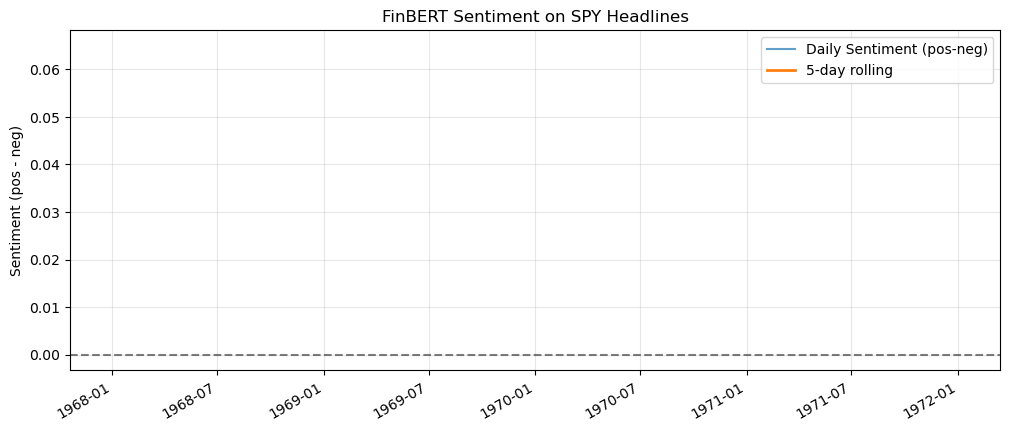

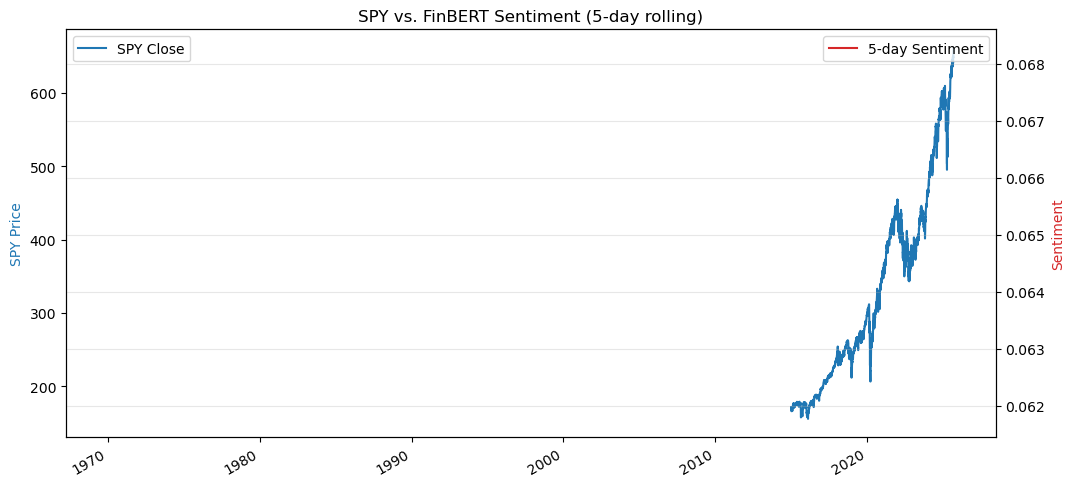

In [65]:
import matplotlib.pyplot as plt

# === Plot sentiment over time ===
plt.figure(figsize=(12,5))
plt.plot(daily["date"], daily["fin_sent_mean"], label="Daily Sentiment (pos-neg)", alpha=0.7)
plt.plot(daily["date"], daily["fin_sent_mean_r5"], label="5-day rolling", linewidth=2)
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.title("FinBERT Sentiment on SPY Headlines")
plt.ylabel("Sentiment (pos - neg)")
plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate()
plt.show()

# === Compare sentiment vs SPY price ===
price = pd.read_csv("data/raw/SPY.csv", index_col=0, parse_dates=True)
plt.figure(figsize=(12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(price.index, price["Close"], color="tab:blue", label="SPY Close")
ax2.plot(daily["date"], daily["fin_sent_mean_r5"], color="tab:red", label="5-day Sentiment")

ax1.set_ylabel("SPY Price", color="tab:blue")
ax2.set_ylabel("Sentiment", color="tab:red")
plt.title("SPY vs. FinBERT Sentiment (5-day rolling)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.grid(alpha=0.3); plt.gcf().autofmt_xdate()
plt.show()
